# Evaluate the classifier's transferability on a tiled dataset from Bern cohorts

In [15]:
import importlib
import os
import functools

import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import numpy as np
from tqdm import tqdm
import seaborn as sns
import pandas as pd

import Abed_utils

## Load and build model

In [11]:
patch_size = 8
batch_size = 8
im_size = 224
path_to_backbone = './ckpts/dino_deitsmall8_pretrain.pth'
path_to_classifier = './ckpts/classifier_K19_CE_100ep_one_layer.pt'

transform = (Abed_utils.normalize_input(im_size=im_size, patch_size=patch_size))

In [26]:
importlib.reload(Abed_utils)
# backbone = Abed_utils.get_vit(patch_size, path_to_backbone)

classifier = Abed_utils.ClassificationHead(pretrained_path=path_to_classifier, dropout=0.2)
# features, labels = Abed_utils.load_features(os.path.join(Abed_utils.OUTPUT_ROOT, 'features'), cuda=True)
# classifier = Abed_utils.KNNClassifier(features, labels)
# model = nn.Sequential(backbone, classifier)
model = classifier
# model.eval()

100%|██████████| 4006/4006 [00:18<00:00, 218.41it/s]


for 001b_B2005.30530_C_HE.mrxs we get an accuracy of 0.7370 and an f1 of 0.7412


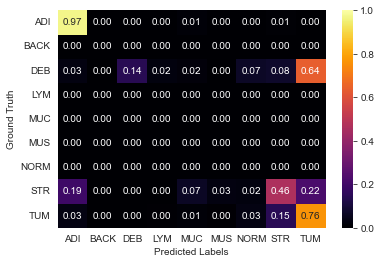

100%|██████████| 3322/3322 [00:15<00:00, 210.94it/s]


for 352b_B2005.5775_F_HE.mrxs we get an accuracy of 0.6393 and an f1 of 0.6472


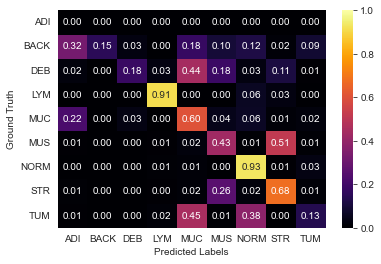

100%|██████████| 3362/3362 [00:15<00:00, 220.36it/s]


for 565c_B2012.15587_B_HE.mrxs we get an accuracy of 0.5932 and an f1 of 0.5643


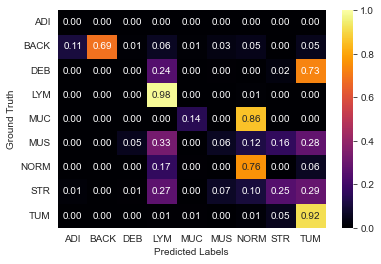

In [21]:
if Abed_utils.BERN_TILES_ROOT is None:
    raise RuntimeError('labelled Bern tiles not available on this machine, run on the dataserver')

os.makedirs(os.path.join(Abed_utils.OUTPUT_ROOT, 'confusion_matrices'), exist_ok=True)

wsis = os.listdir(Abed_utils.BERN_TILES_ROOT)
with torch.no_grad():
    for wsi in wsis:

        # ds = ImageFolder(os.path.join(Abed_utils.BERN_TILES_ROOT, wsi), transform=transform)
        features, labels = Abed_utils.load_features(os.path.join(Abed_utils.OUTPUT_ROOT, f'features-{wsi}'), cuda=True)
        # print(torch.unique(labels))
        # break
        ds = TensorDataset(features, labels)
        data = DataLoader(ds, batch_size=batch_size)
        preds = np.empty(len(ds))
        targets = np.empty_like(preds)
        for i, (x, y) in enumerate(tqdm(data)):
            idx = slice(i*batch_size,min((i+1)*batch_size, preds.shape[0]))
            predictions = model(x.cuda()).cpu().numpy()
            preds[idx] = predictions if len(predictions.shape) < 2 else predictions.argmax(axis=1)
            targets[idx] = y.cpu().numpy()
        # print(f'Predictions {np.unique(preds)}')
        acc = (preds == targets).mean()
        f1 = f1_score(targets, preds, average='weighted')
        print(f'for {wsi} we get an accuracy of {acc:.4f} and an f1 of {f1:.4f}')
        cmatrix = confusion_matrix(targets, preds, normalize='true')
        for i in range(9):
            if i not in preds and i not in targets:
                cmatrix = np.insert(cmatrix, i, np.zeros(cmatrix.shape[1]), 0)
                cmatrix = np.insert(cmatrix, i, np.zeros(cmatrix.shape[0]), 1)

        np.save(os.path.join(Abed_utils.OUTPUT_ROOT, 'confusion_matrices', f'{wsi}_KNN'), cmatrix)
        sns.heatmap(cmatrix, cmap='inferno', annot=True, fmt='.2f', vmin=0, vmax=1,
                    xticklabels=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'],
                    yticklabels=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'])
        plt.xlabel('Predicted Labels')
        plt.ylabel('Ground Truth')
        plt.show()



100%|██████████| 10689/10689 [00:08<00:00, 1226.83it/s]


for 565c_B2012.15587_B_HE.mrxs we get an accuracy of 0.5144 and an f1 of 0.4463


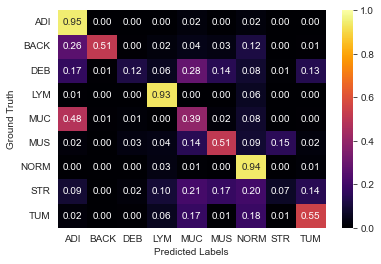

In [27]:
if Abed_utils.BERN_TILES_ROOT is None:
    raise RuntimeError('labelled Bern tiles not available on this machine, run on the dataserver')

wsis = os.listdir(Abed_utils.BERN_TILES_ROOT)
features, labels = None, None
with torch.no_grad():
    for wsi in wsis:

        # ds = ImageFolder(os.path.join(Abed_utils.BERN_TILES_ROOT, wsi), transform=transform)
        f, l = Abed_utils.load_features(os.path.join(Abed_utils.OUTPUT_ROOT, f'features-{wsi}'), cuda=True)
        if features is None:
            features = f
        else:
            features = torch.concat((features, f), dim=0)
        if labels is None:
            labels = l
        else:
            labels = torch.concat((labels, l), dim=0)

        # print(torch.unique(labels))
        # break
    ds = TensorDataset(features, labels)
    data = DataLoader(ds, batch_size=batch_size)
    preds = np.empty(len(ds))
    targets = np.empty_like(preds)
    for i, (x, y) in enumerate(tqdm(data)):
        idx = slice(i*batch_size,min((i+1)*batch_size, preds.shape[0]))
        predictions = model(x.cuda()).cpu().numpy()
        preds[idx] = predictions if len(predictions.shape) < 2 else predictions.argmax(axis=1)
        targets[idx] = y.cpu().numpy()
    # print(f'Predictions {np.unique(preds)}')
    acc = (preds == targets).mean()
    f1 = f1_score(targets, preds, average='weighted')
    print(f'for {wsi} we get an accuracy of {acc:.4f} and an f1 of {f1:.4f}')
    cmatrix = confusion_matrix(targets, preds, normalize='true')
    for i in range(9):
        if i not in preds and i not in targets:
            cmatrix = np.insert(cmatrix, i, np.zeros(cmatrix.shape[1]), 0)
            cmatrix = np.insert(cmatrix, i, np.zeros(cmatrix.shape[0]), 1)
    sns.heatmap(cmatrix, cmap='inferno', annot=True, fmt='.2f', vmin=0, vmax=1,
                xticklabels=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'],
                yticklabels=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('Ground Truth')
    plt.show()



In [22]:

results = [['001b_B2005.30530_C_HE.mrxs', 0.7412, 0.5564],
           ['352b_B2005.5775_F_HE.mrxs', 0.6472, 0.5133],
           ['565c_B2012.15587_B_HE.mrxs', 0.5643, 0.4370]]
results = pd.DataFrame(results, columns=['ROI_filename', 'knn_f1', 'linear_f1'])
results.to_csv(os.path.join(Abed_utils.OUTPUT_ROOT, 'classifier_hist', 'f1_scores.csv'))

In [28]:
np.save(os.path.join(Abed_utils.OUTPUT_ROOT, 'confusion_matrices', 'all_Linear'), cmatrix)

0.6614 and an f1 of 0.6439 for all 3 ROIs KNN
0.5144 and an f1 of 0.4463 for all 3 ROIs Linear